In [307]:
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler


def fetch_historical_data(symbol, interval='1d', start_date=None, end_date=None, limit=1000):
    url = f'https://api.binance.com/api/v3/klines?symbol={symbol}&interval={interval}&limit={limit}'
    
    if start_date:
        url += f'&startTime={int(pd.Timestamp(start_date).timestamp() * 1000)}'
    if end_date:
        url += f'&endTime={int(pd.Timestamp(end_date).timestamp() * 1000)}'
    
    response = requests.get(url)
    
    if response.status_code != 200:
        raise Exception(f'Error fetching data: {response.status_code} - {response.text}')
    
    data = response.json()
    
    df = pd.DataFrame(data, columns=[
        'timestamp', 'open', 'high', 'low', 'close', 'volume',
        'close_time', 'quote_asset_volume', 'number_of_trades',
        'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'
    ])
    
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    df.drop(columns=['close_time', 'ignore'], inplace=True)
    
    # Convert columns to numeric
    df = df.apply(pd.to_numeric, errors='coerce')
    
    df['price_range'] = df['high'] - df['low']
    df['close_to_open'] = df['close'] - df['open']
    
    return df

# Example of fetching data
symbol = 'BTCUSDT'  # Example: Bitcoin to USD
# symbol = 'ETHUSDT'  
df = fetch_historical_data(symbol, start_date='2022-06-01', end_date='2025-02-06')
df.head()


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,price_range,close_to_open
timestamp,,,,,,,,,,,
2022-06-01,31801.05,31982.97,29301.00,29805.83,103395.63382,3.171191e+09,1404611,47614.81205,1.460767e+09,2681.97,-1995.22
2022-06-02,29805.84,30689.00,29594.55,30452.62,56961.42928,1.711653e+09,1086183,28555.06607,8.581935e+08,1094.45,646.78
2022-06-03,30452.63,30699.00,29282.36,29700.21,54067.44727,1.615617e+09,993769,26583.25141,7.943548e+08,1416.64,-752.42
2022-06-04,29700.21,29988.88,29485.00,29864.04,25617.90113,7.608743e+08,618037,12971.72460,3.853582e+08,503.88,163.83
2022-06-05,29864.03,30189.00,29531.42,29919.21,23139.92810,6.912015e+08,604680,11753.51303,3.511506e+08,657.58,55.18


In [308]:
df.shape

(982, 11)

<Axes: >

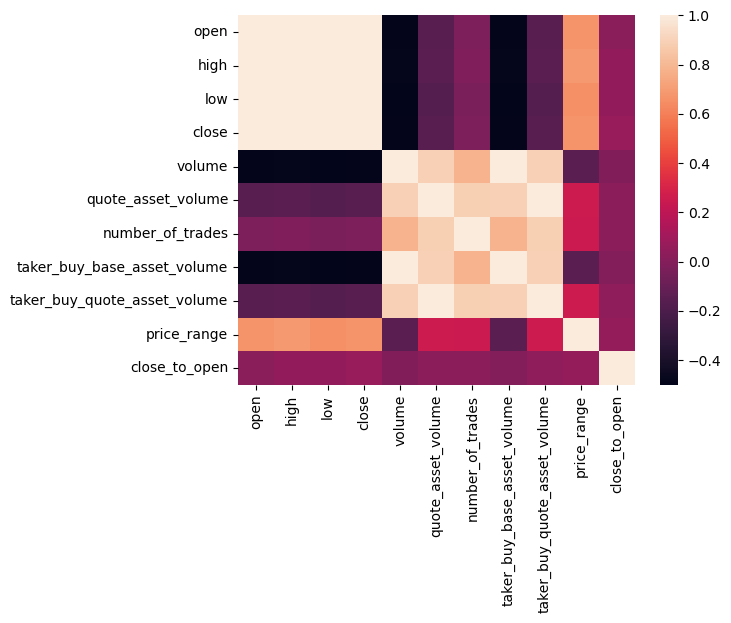

In [309]:
import seaborn as sns

sns.heatmap(df.corr())

In [310]:
# Preprocessing: Shift the target (closing price) by -1 to predict the next day's closing price
df['target'] = df['close'].shift(-1)

# Drop the last row because it will have a NaN target (due to the shift)
df = df.dropna()

features = ['open', 'high', 'low', 'volume', 'quote_asset_volume',
       'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'price_range', 'close_to_open']




In [311]:
X = df[features]
y = df['target']  # Target variable: next day's closing price



In [312]:
# Split the data into training and testing sets
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]



In [313]:
from sklearn.preprocessing import MinMaxScaler

# Apply Min-Max scaling to the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Display scaled features
pd.DataFrame(X_train_scaled, columns=X.columns).head()


,open,high,low,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,price_range,close_to_open
0,0.279620,0.272667,0.247506,0.127538,0.169644,0.073344,0.118211,0.155086,0.262880,0.317681
1,0.244795,0.250148,0.252761,0.065905,0.084858,0.051991,0.066840,0.085564,0.102866,0.545918
2,0.256084,0.250322,0.247172,0.062064,0.079279,0.045794,0.061525,0.078199,0.135341,0.425044
3,0.242951,0.237964,0.250800,0.024302,0.029626,0.020599,0.024838,0.031010,0.043339,0.504197
4,0.245810,0.241447,0.251631,0.021013,0.025579,0.019703,0.021555,0.027064,0.058831,0.494811


In [314]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)


LinearRegression()

In [315]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import numpy as np
y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
root_mean_squared_error = np.sqrt(mse)
print(f'Root Mean Squared Error: {root_mean_squared_error}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')



Root Mean Squared Error: 2072.2537247777286
Mean Absolute Error: 1516.2121845211605
Mean Squared Error: 4294235.49985517


In [316]:
predictions = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
predictions.tail()


,Actual,Predicted
timestamp,,
2025-02-01,97700.59,101245.989190
2025-02-02,101328.52,98763.665696
2025-02-03,97763.13,100397.875680
2025-02-04,96612.43,98516.964581
2025-02-05,98171.29,97768.983779
